In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

# Read single NetCDF file
using the Xarray package: https://xarray.pydata.org/en/stable/

In [38]:
ds=xr.open_dataset('ssp585/t2m/tasIs_LImon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc')

/Users/leo/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'tasIs' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [14]:
ds.tasIs.comment

'quantity averaged over ice_sheet (meaning grounded ice sheet and floating ice shelf) only, to avoid contamination from other surfaces (eg: permafrost)'

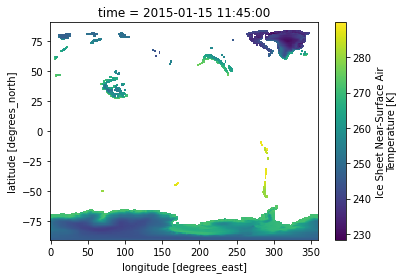

In [15]:
ds.tasIs[0].plot()

# Read multiple files at once
Use this when reading multiple time series of the same variable

https://xarray.pydata.org/en/stable/io.html?reading-multi-file-datasets

In [39]:
ds=xr.open_mfdataset('ssp585/t2m/tas_Amon_*.nc',combine='by_coords')

/Users/leo/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


# Antarctica mask

In [17]:
ds2 = xr.open_dataset('cam_LANDFRAC.nc')

In [18]:
landfrac = ds2.LANDFRAC.squeeze()

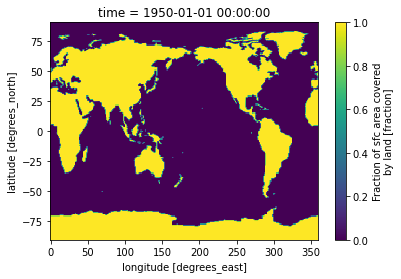

In [32]:
#landfrac[0:100,0:100].plot()
landfrac.plot()

In [20]:
lon = ds.lon
lat = ds.lat
lon2d, lat2d = np.meshgrid(lon,lat)

In [21]:
ais_mask = xr.where(lat2d<-60., landfrac, 0)
ais_mask.name = 'AIS_MASK'
ais_mask = ais_mask.reset_coords('time', drop=True) # drop time dimension

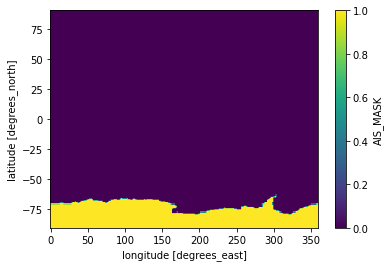

In [22]:
ais_mask.plot()

# Time series of mean annual temperature over AIS
To calculate a area-weighted mean temperature, we need to know what is the area of AIS. For this we read the `areacella` variable. 

In [23]:
ds_area = xr.open_dataset('fx/areacella_fx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc')
area = ds_area.areacella

/Users/leo/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [24]:
total_area_AIS = (ais_mask * area).sum().item()
print(total_area_AIS, area.units)

14162570772480.0 m2


In [33]:
total_area_AIS/1e6

14162570.77248

### Step 1: convert monthly to annual data

In [40]:
# days per month, assuming no leap years
dpm = np.array((31 ,28 ,31 ,30 ,31 ,30 ,31 ,31 ,30 ,31 ,30 ,31 )) 


def mul_with_dpm(data):
    """
    This helper function multiplies a monthly array (e.g. Xarray DataArray) with the number
    of days per month, and then divides by the total of days in the year. 
    """
    return (data * dpm[:,np.newaxis,np.newaxis]).sum(dim='time') / dpm.sum()

def monthly_to_yearly(data):
    """
    This function converts a 'timeseries' of monthly data to a timeseries of yearly data. 
    An approximation to this function is: 
    
        data.groupby('time.year').mean()
        
    But that doesn't take into account the different lengths of the months. 

    NOTE:
        This function assumes a 365-day calendar for each year (no leap, as is common in climate models).
    """
    out = data.groupby('time.year').apply(mul_with_dpm)
    out.attrs = data.attrs
    return out

Convert monthly data into annual data using either:
* Method 1: simple grouping per year
* Method 2: weighing the number of days per month

These methods will give a comparable, but slightly different answer. Let's go with method 2 since it's more accurate. 

In [42]:
#t2m_ann = ds.tas.groupby('time.year').mean() # Method 1
t2m_ann = monthly_to_yearly(ds.tas) # Method 2

In [43]:
t2m_ann.shape

(285, 192, 288)

### Step 2: calculate AIS average

In [44]:
t2m_ann_ais = (t2m_ann * ais_mask.values * area).sum(dim=['lat','lon'])/total_area_AIS

In [45]:
t2m_ann_ais.load();

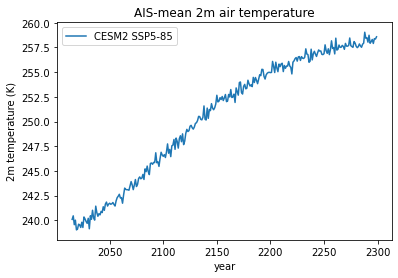

In [46]:
t2m_ann_ais.plot(label='CESM2 SSP5-85')
plt.title('AIS-mean 2m air temperature')
plt.ylabel('2m temperature (K)');
plt.legend()

# Elevation

In [47]:
ds=xr.open_dataset('ssp585/fx/orog_fx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc')

/Users/leo/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'orog' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [59]:
ds.orog

<xarray.DataArray 'orog' (lat: 192, lon: 288)>
array([[2879.556 , 2879.556 , 2879.556 , ..., 2879.556 , 2879.556 , 2879.556 ],
       [2757.7576, 2760.9363, 2764.4756, ..., 2748.1736, 2751.338 , 2754.6467],
       [2672.5293, 2679.2312, 2686.1196, ..., 2652.755 , 2659.2878, 2665.9136],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean
    comment:        chunits(PHIS[0,:,:]/9.80616,units="m")
    description:    height above the geoid; as defined here, "the geoid" is a...
    frequency:      fx
    id:             orog
    long_name:      Surface Altitude
    mipTable:       fx
    out_name:       orog
    prov:           fx ((isd.003))
    realm:          land
    standard_name:  surface_altitude
    time_label:     None
    time_title:     No temporal dimensions ... fixed field
    title:          Surface Altitude
    type:           real
    units:          m
    variable_id:    orog

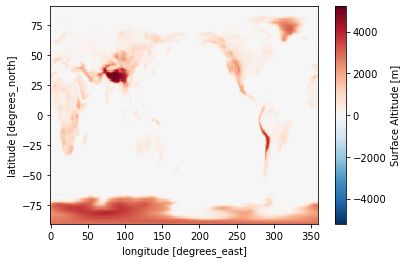

In [50]:
ds.orog.plot()

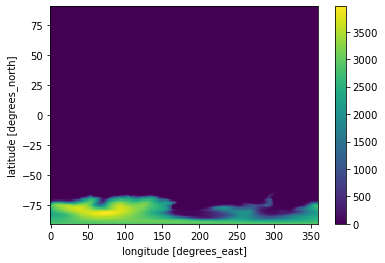

In [53]:
(ds.orog*ais_mask).plot()

In [54]:
ais_oro = ds.orog*ais_mask

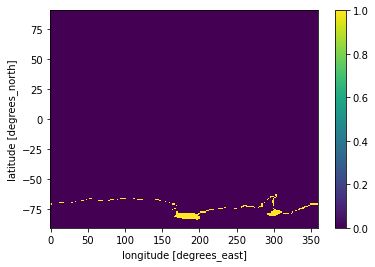

In [58]:
xr.where((ais_oro > 0.1) * (ais_oro < 100), 1, 0).plot()